<a href="https://colab.research.google.com/github/SofiaFreiman/Lung_epitelium/blob/main/Trajectory_and_branching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scanpy leidenalg scikit-misc adjustText gseapy bbknn cellrank scvelo
import os
os.kill(os.getpid(), 9)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import time
import os
import pandas as pd
import numpy as np
import scipy.stats
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.external as sce
import anndata
from matplotlib_venn import venn3
from matplotlib_venn import venn2

sc.settings.verbosity = 1
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

In [ ]:
plt.rcParams['font.family'] = 'Liberation Serif'

In [ ]:
l2_colors = {'Basal cells': 'tab:green', 'Suprabasal cells': 'darkseagreen', 'Goblet cells': 'mediumaquamarine', 'Secretory cells': 'burlywood', 'Ciliated cells': 'mediumpurple', 'Ionocytes': 'orangered', 'Deuterosomal cells': 'deeppink'}
l3_colors = {'Basal cells' : "tab:green", 'Suprabasal cells' : "darkseagreen", "Goblet cells" : "mediumaquamarine", "Secretory cells" : "burlywood", "FOS/JUN-positive" : "cornflowerblue", "FOS/JUN-negative" : "mediumpurple", "Ionocytes" : "orangered", "Deuterosomal cells" : "deeppink"}
path = "drive/MyDrive/LU/Pavan_data/"
path_figs = "drive/MyDrive/LU/Pavan_data/figs/"

In [ ]:
adata = sc.read(path + "adata_current.h5ad")

In [ ]:
adata.obs['anno_l2_tmp'] = adata.obs['anno_l2'].replace({'Basal cells' : 'Basal\ncells', 'Ciliated cells' : 'Ciliated\ncells', 'Deuterosomal cells' : 'Deuterosomal\ncells', 'Goblet cells' : 'Goblet\ncells', 'Secretory cells' : 'Secretory\ncells', 'Suprabasal cells' : 'Suprabasal\ncells'})
adata.obs['anno_l2_tmp'] = adata.obs['anno_l2_tmp'].cat.reorder_categories(['Basal\ncells', 'Suprabasal\ncells', 'Goblet\ncells', 'Secretory\ncells', 'Ciliated\ncells', 'Ionocytes', 'Deuterosomal\ncells'])
adata.obs['age_group'] = adata.obs['sname'].replace({'Sample17H-quant_res' : "young", 'Sample_21-quant_res' : "young", 'nextseq1.Sample1-quant_res' : "young", 'Sample18H-quant_res' : 'aged',
                                                     'nextseq4.Sample_9-quant_res' : "young", 'nextseq5.Sample11-quant_res' : "aged", 'nextseq3.sample_1-quant_res': "young",
                                                     'nextseq3.sample_2-quant_res' : "young", 'nextseq6.Pavan1_S1-quant_res' : "aged", 'nextseq5.Sample10-quant_res' : "young"})

## Trajectory analysis

In [ ]:
pd.crosstab(adata.obs['age_group'], adata.obs['sname'])

sname,Sample17H-quant_res,Sample18H-quant_res,Sample_21-quant_res,nextseq1.Sample1-quant_res,nextseq3.sample_1-quant_res,nextseq3.sample_2-quant_res,nextseq4.Sample_9-quant_res,nextseq5.Sample10-quant_res,nextseq5.Sample11-quant_res,nextseq6.Pavan1_S1-quant_res
age_group,,,,,,,,,,
young,1719,0,123,32,20,42,9,2284,0,0
aged,0,1692,0,0,0,0,0,0,552,6043


TACGTCCTCTTTACAC-1-0-0-0-0-0-0-0-0-0-0-0
AGAGAGCCAACTCCCT-1-0-0-0-0-0-0-0-0-0-0-0-0
GAGAGGTAGTCTAGAA-1
GTCCTCACACTCAAGT-1-0


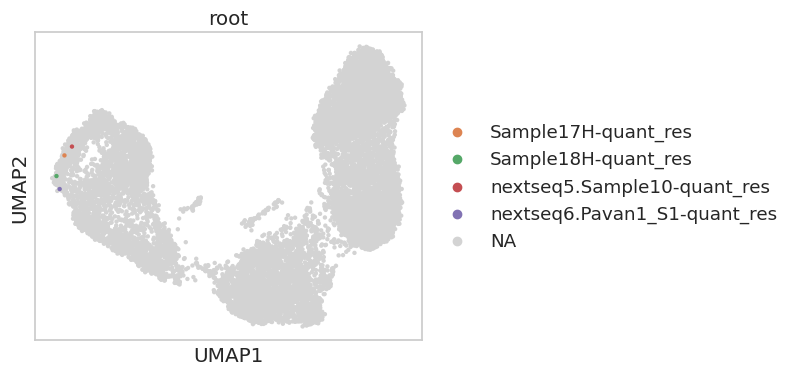

In [ ]:
## Root are high in TP63

adata.obs['root'] = np.full(len(adata), 'False')
exps = list(set(adata.obs['sname']))

for exp in exps:
  ## Find root
  if exp in ["Sample17H-quant_res", "Sample18H-quant_res", "nextseq6.Pavan1_S1-quant_res", 'nextseq5.Sample10-quant_res']:
    adx = adata[(adata.obs['sname']==exp) & (adata.obs['anno']=='Basal cells')]
    x = adx.obs_vector('TP63', layer='X')
    iroot = int(np.where(x==np.max(x))[0][0])  ## In subset.
    iroot = np.where(adata.obs.index==adx.obs_names[iroot])[0][0]  ## In superset.
    adata.obs['root'].iloc[iroot] = exp
    print(adata.obs_names[iroot])

adata.obs['root'] = adata.obs['root'].astype('category')

fig, ax = plt.subplots(figsize=(5, 4))
ax = sc.pl.umap(adata, color=['root'], groups=exps, ax=ax, size=40, show=False)

In [ ]:
iroot = int(np.where(adata.obs['root']=="Sample17H-quant_res")[0][0])
sroot = adata.obs_names[iroot]
print("Root cell", iroot, "---", sroot)
adata.uns['iroot'] = iroot

Root cell 12358 --- GAGAGGTAGTCTAGAA-1


In [ ]:
sc.tl.diffmap(adata)

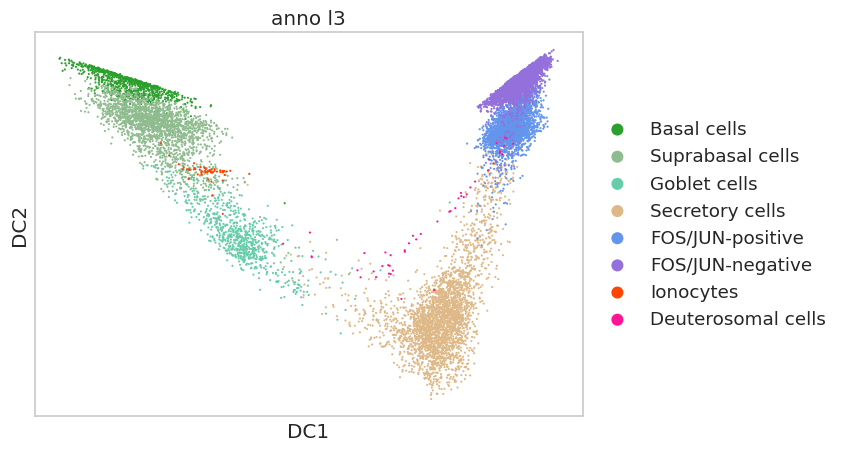

In [ ]:
sc.pl.scatter(adata, basis="diffmap", color=["anno_l3",], components=[1, 2])

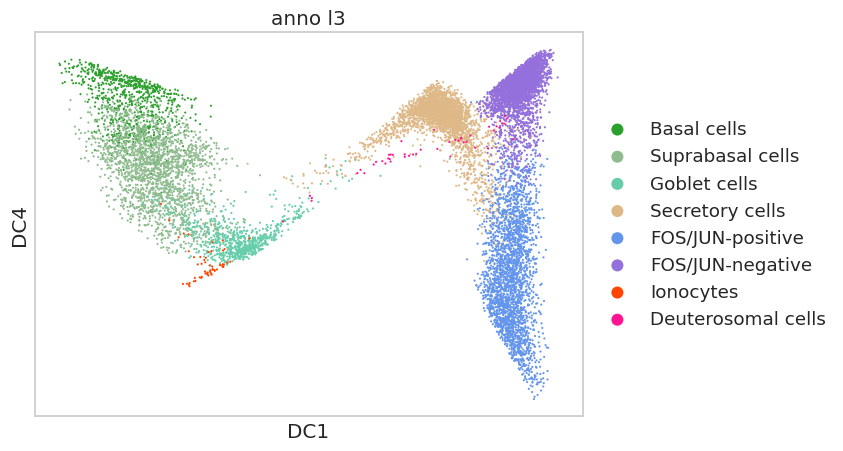

In [ ]:
sc.pl.scatter(adata, basis="diffmap", color=["anno_l3",], components=[1, 4])

In [ ]:
sc.tl.dpt(adata, n_branchings=0)

<Axes: title={'center': 'Diffusion pseudotime'}>

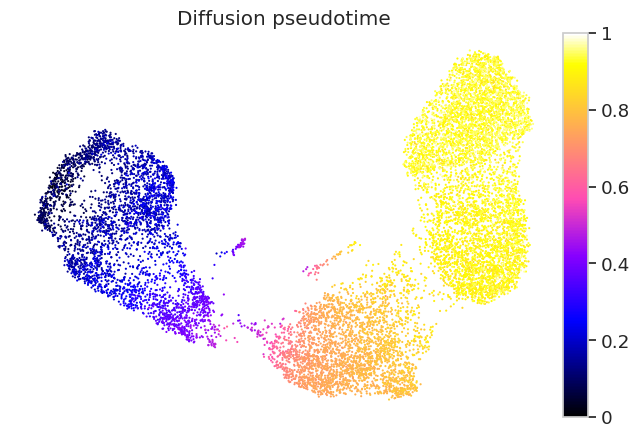

In [ ]:
sns.set(font_scale = 1.2)
sns.set_style('whitegrid')
sc.pl.scatter(adata, basis="umap", color=["dpt_pseudotime"], color_map="gnuplot2", show = False, title = "Diffusion pseudotime", frameon = False)

In [ ]:
ribo = adata.var_names[adata.var['ribo'] == True].to_list()
len(ribo)

100

In [ ]:
sc.tl.score_genes(adata, ribo, ctrl_size=500, n_bins=25, score_name='ribo_score', random_state=0, copy=False)

In [ ]:
set(adata.obs['anno_l3'])

{'Basal cells',
 'Ciliated-1',
 'Ciliated-2',
 'Deuterosomal cells',
 'Goblet cells',
 'Ionocytes',
 'Secretory cells',
 'Suprabasal cells'}

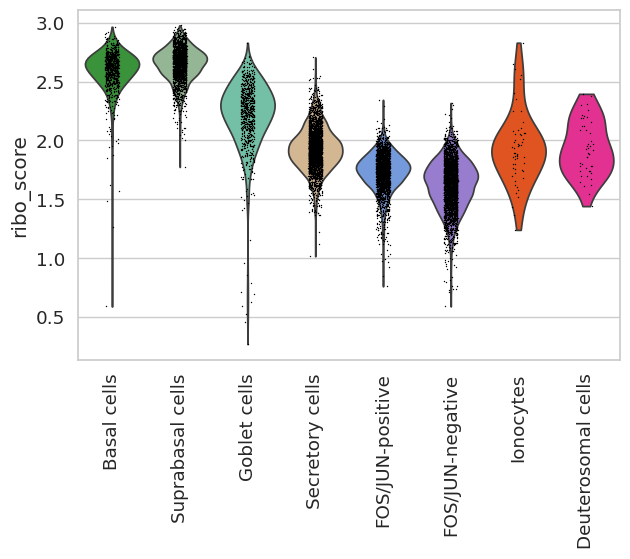

In [ ]:
sc.pl.violin(adata, keys=["ribo_score",], groupby="anno_l3", order = ['Basal cells', "Suprabasal cells", "Goblet cells", "Secretory cells",  "FOS/JUN-positive", "FOS/JUN-negative", "Ionocytes", 'Deuterosomal cells'], rotation=90,)

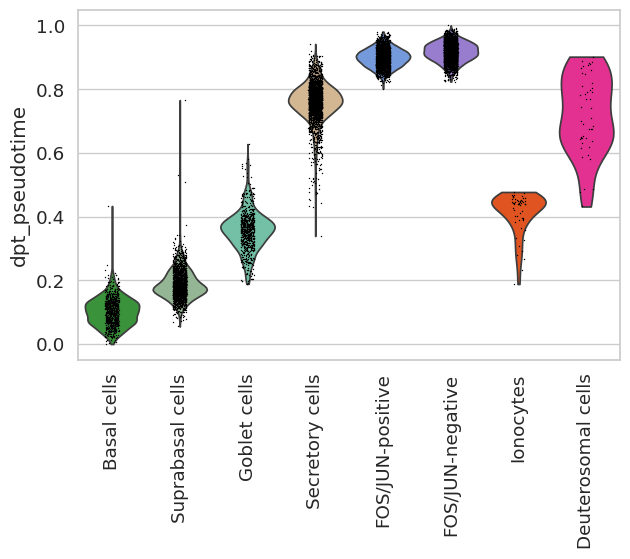

In [ ]:
sc.pl.violin(adata, keys=["dpt_pseudotime",], groupby="anno_l3", order = ['Basal cells', "Suprabasal cells", "Goblet cells", "Secretory cells",  "FOS/JUN-positive", "FOS/JUN-negative", "Ionocytes", 'Deuterosomal cells'], rotation=90,)

## Branches

In [ ]:
ct_colors_1 = {'Basal cells': 'tab:green', 'Suprabasal\ncells': 'darkseagreen', 'Goblet cells': 'mediumaquamarine', 'Secretory cells': 'burlywood',
               'FOS/JUN-positive': 'cornflowerblue', 'FOS/JUN-negative': 'mediumpurple', 'Ionocytes': 'orangered', 'Deuterosomal\ncells': 'deeppink'}

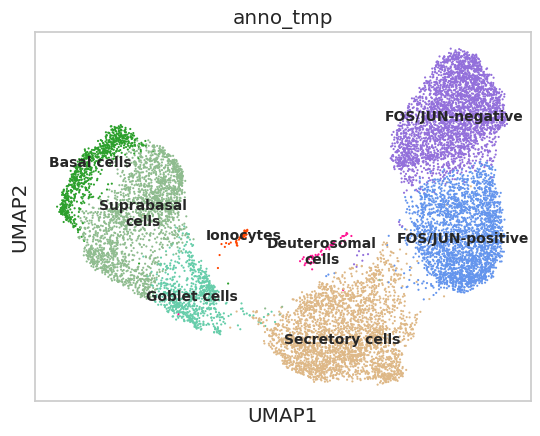

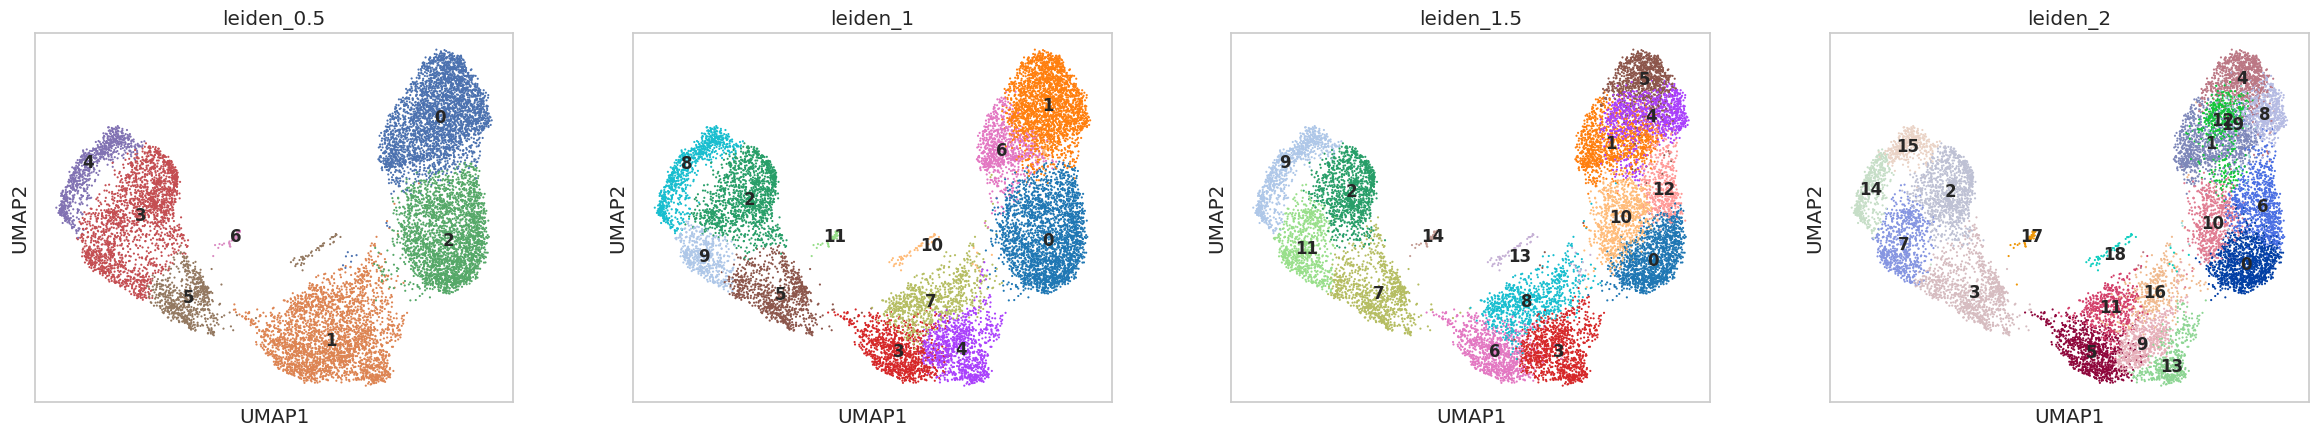

In [ ]:
adata.obs['anno_tmp'] = adata.obs['anno_l3'].replace({"Deuterosomal cells" : "Deuterosomal\ncells", 'Suprabasal cells' : 'Suprabasal\ncells'})
sc.pl.umap(adata, color = ["anno_tmp"], palette = ct_colors_1, legend_loc = 'on data', legend_fontsize=10)
sc.pl.umap(adata, color = [i for i in adata.obs.columns if "leiden" in i], legend_loc = 'on data', ncols = 5, legend_fontsize=12)

In [ ]:
sc.tl.paga(adata, groups='leiden_1.5')

<Axes: >

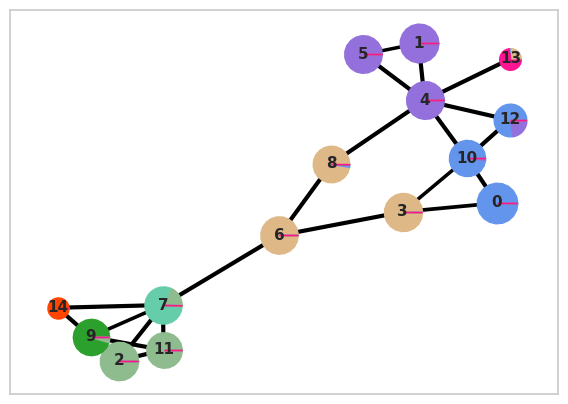

In [ ]:
sc.pl.paga(adata, color = 'anno_l3', show = False, threshold = 0.8, layout = "fa", random_state = 1, node_size_scale = 5, node_size_power = 0.4, edge_width_scale = 0.4, fontsize=11, fontweight='bold')

<Axes: >

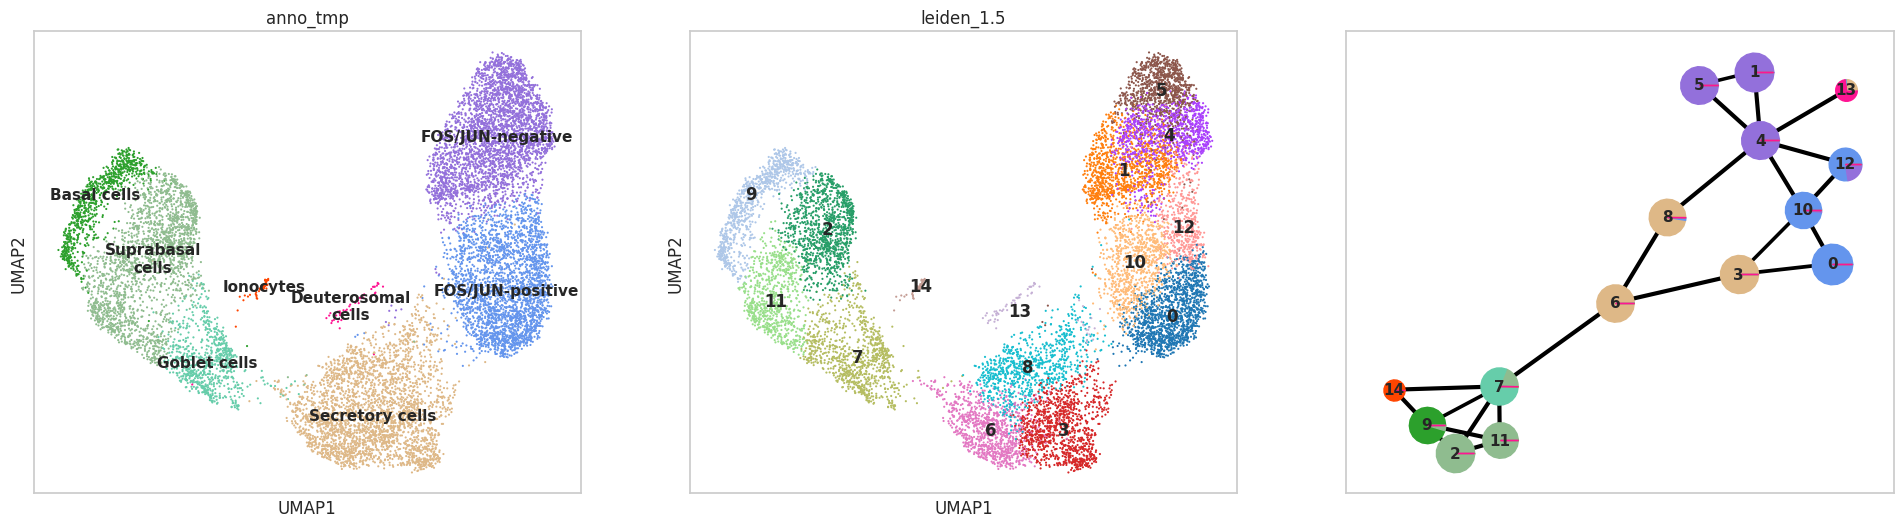

In [ ]:
sns.set(font_scale = 1)
sns.set_style('whitegrid')
fig, axs = plt.subplots(1, 3, figsize = (24, 6))
sc.pl.umap(adata, color = ["anno_tmp"], ax = axs[0], show = False, legend_loc = 'on data', legend_fontsize=11)
sc.pl.umap(adata, color = ["leiden_1.5"], ax = axs[1], show = False, legend_loc = 'on data', legend_fontsize=12)
sc.pl.paga(adata, color = 'anno_l3', show = False, threshold = 0.8, layout = "fa", random_state = 1, node_size_scale = 5, node_size_power = 0.4, edge_width_scale = 0.4, fontsize=11, fontweight='bold', ax = axs[2])

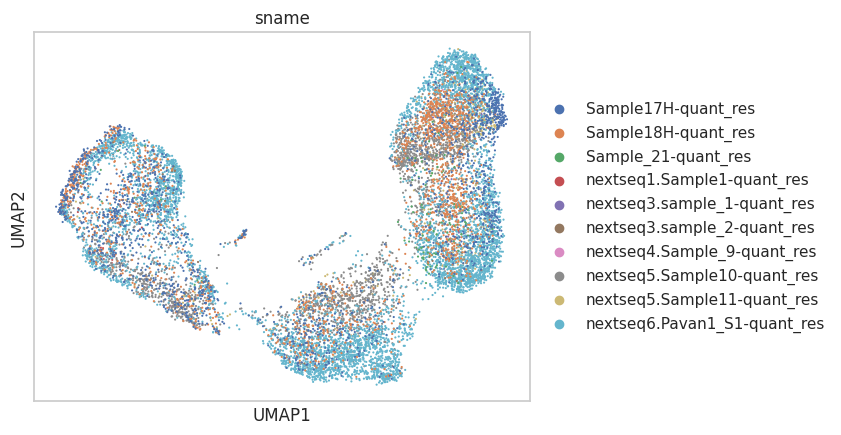

In [ ]:
sc.pl.umap(adata, color = 'sname')

In [ ]:
pd.crosstab(adata.obs['sname'], adata.obs['leiden_1.5'], margins = True)

leiden_1.5,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,All
sname,,,,,,,,,,,,,,,,
Sample17H-quant_res,134,76,188,58,285,54,98,203,77,204,47,163,105,12,15,1719
Sample18H-quant_res,91,93,151,60,405,30,91,115,108,185,221,81,38,5,18,1692
Sample_21-quant_res,9,11,6,0,15,4,0,3,0,4,70,1,0,0,0,123
nextseq1.Sample1-quant_res,3,0,2,0,4,0,0,0,0,6,7,10,0,0,0,32
nextseq3.sample_1-quant_res,3,0,1,0,8,0,3,1,0,0,4,0,0,0,0,20
nextseq3.sample_2-quant_res,3,2,9,0,6,0,1,6,0,4,9,0,1,0,1,42
nextseq4.Sample_9-quant_res,0,0,0,0,3,1,0,3,0,0,1,0,0,0,1,9
nextseq5.Sample10-quant_res,15,743,25,63,41,41,116,339,518,21,158,161,19,20,4,2284
nextseq5.Sample11-quant_res,68,76,10,16,155,48,20,27,48,11,30,5,32,5,1,552
